***Question: do NBA teams win more games at home court?***

In [119]:
from pathlib import Path
import pandas as pd
import numpy as np

games_csv_path = Path('../data/nba_games_data/games.csv') 
assert games_csv_path.exists()

Explore the dataset a bit.

In [120]:
all_games = pd.read_csv(games_csv_path).sort_values('GAME_DATE_EST', ascending=False)

In [121]:
print(all_games.head(2))

  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2022-03-12  22101005            Final    1610612748       1610612750   
4    2022-03-12  22101009            Final    1610612743       1610612761   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  AST_home  \
0    2021    1610612748     104.0        0.398         0.76  ...      23.0   
4    2021    1610612743     115.0        0.551         0.75  ...      32.0   

   REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  \
0      53.0    1610612750     113.0        0.422        0.875         0.357   
4      39.0    1610612761     127.0        0.471        0.760         0.387   

   AST_away  REB_away  HOME_TEAM_WINS  
0      21.0      46.0               0  
4      28.0      50.0               0  

[2 rows x 21 columns]


In [122]:
print(all_games.tail(2))

      GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
18432    2003-10-06  10300002            Final    1610612763       1610612749   
18433    2003-10-05  10300001            Final    1610612762       1610612742   

       SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  \
18432    2003    1610612763     105.0        0.494        0.618  ...   
18433    2003    1610612762      90.0        0.457        0.735  ...   

       AST_home  REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT_PCT_away  \
18432      25.0      48.0    1610612749      94.0        0.427          0.7   
18433      23.0      41.0    1610612742      85.0        0.447          0.5   

       FG3_PCT_away  AST_away  REB_away  HOME_TEAM_WINS  
18432         0.154      20.0      43.0               1  
18433         0.250      20.0      38.0               1  

[2 rows x 21 columns]


In [123]:
num_games = all_games.shape[0]
first_season = all_games.SEASON.min()
last_season = all_games.SEASON.max()

print(f'There are totally {num_games} games in this dataset.')
print(f'The dataset spans from {first_season} season to {last_season} season')
print(f'The oldest game played in {all_games.GAME_DATE_EST.min()}.')
print(f'The latest game played in {all_games.GAME_DATE_EST.max()}.')

There are totally 25796 games in this dataset.
The dataset spans from 2003 season to 2021 season
The oldest game played in 2003-10-05.
The latest game played in 2022-03-12.


Among all the games, how many are won by home teams? Let's take a look.

In [124]:
num_total_home_win = all_games.HOME_TEAM_WINS.sum() 
ratio_total_home_win = num_total_home_win / num_games

print(f'Total number of home win is {num_total_home_win} out of total {num_games} games.')
print(f'In total, the ratio of home win is {ratio_total_home_win:.2%} among all games in this dataset.')

Total number of home win is 15155 out of total 25796 games.
In total, the ratio of home win is 58.75% among all games in this dataset.


**Can we say that NBA teams win more at home?**  
A 58.8% ratio do not give us lots of confidence to say so.  
In different seasons there might be (drastically) different ratio.  
Let's look at the games season by season.

In [125]:
all_seasons = range(first_season, last_season+1)
home_win_ratio_all_seasons = []
for s in all_seasons:
    games = all_games[all_games['SEASON'] == s]
    n_games = games.shape[0]
    n_home_wins = games.HOME_TEAM_WINS.sum()
    home_win_ratio_all_seasons.append(n_home_wins / n_games)
home_win_ratio_all_seasons = np.array(home_win_ratio_all_seasons)

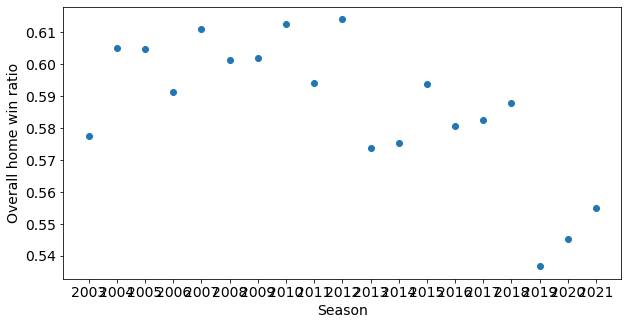

In [126]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 5))
plt.scatter(all_seasons, home_win_ratio_all_seasons)
plt.xticks(all_seasons)
plt.xlabel('Season')
plt.ylabel('Overall home win ratio')
plt.show()

Is that all these seasons have a home win ratio lager than 0.5? Let's confirm.

In [127]:
assert all(home_win_ratio_all_seasons > 0.5)

So, for all the seasons from 2003 to 2021, overall, there are more home-wins than away-wins.  
(home-win: won by home team, away-win: won by visiting team)

**How about different teams?   
It maybe that the good teams just won more games (home-games and away-games) and then  
inflated the overall home win ratio across each seaon.**  
Let's verify.

But first, we need to ask a question: **what is a good team?**

To simplify things, let's see a playoff team is better than a non-playoff team in each conference.   
I believe most NBA fans will agree with this. However, a bipartite division of Eastern, Western  
conferences is still somewhat arbitrary.  
So let's see a playoff team is a good team and a non-playoff team is a bad team.  

First, let's have the team information ready.

In [128]:
teams_csv_path = Path('../data/nba_games_data/teams.csv')
assert teams_csv_path.exists()

teams = pd.read_csv(teams_csv_path)
assert teams.shape[0] == 30  # total 30 teams in NBA

print(teams.head(2))

   LEAGUE_ID     TEAM_ID  MIN_YEAR  MAX_YEAR ABBREVIATION NICKNAME  \
0          0  1610612737      1949      2019          ATL    Hawks   
1          0  1610612738      1946      2019          BOS  Celtics   

   YEARFOUNDED     CITY             ARENA  ARENACAPACITY          OWNER  \
0         1949  Atlanta  State Farm Arena        18729.0   Tony Ressler   
1         1946   Boston         TD Garden        18624.0  Wyc Grousbeck   

   GENERALMANAGER     HEADCOACH DLEAGUEAFFILIATION  
0  Travis Schlenk  Lloyd Pierce      Erie Bayhawks  
1     Danny Ainge  Brad Stevens    Maine Red Claws  


In [129]:
# TODO: put this into a utils module or make a api for the data files
def team_nickname(team_id: int) -> str:
    return teams.loc[teams['TEAM_ID'] == team_id, 'NICKNAME'].iloc[0]

assert team_nickname(1610612738) == 'Celtics'

In [130]:
from typing import Set

# TODO: put this into a utils module or make a api for the data files
def playoff_team_ids(season_games: pd.DataFrame) -> Set[int]:
    """
    return team ids of all playoff teams in a season
    
    season_games -- all the games in a season, including regular and playoff games,
                    may include preseason games.
                    
    Note: the 16 teams that played later in the season are the playoff teams  
    """
    home_team_ids = season_games.sort_values('GAME_DATE_EST', ascending=False).HOME_TEAM_ID
    team_ids = set()
    for id in home_team_ids:
        if id not in team_ids:
            team_ids.add(id)
        if len(team_ids) == 16:
            break 
    return team_ids

# TODO: put this into a utils module or make a api for the data files
def non_playoff_team_ids(season_games: pd.DataFrame) -> Set[int]: 
    return set(teams.TEAM_ID) - playoff_team_ids(season_games)

In [131]:
games_2009 = all_games[all_games['SEASON'] == 2009]
names_2009_playoff = set(team_nickname(id) for id in playoff_team_ids(games_2009))
assert len(names_2009_playoff) == 16

names_2009_non_playoff = set(team_nickname(id) for id in non_playoff_team_ids(games_2009))
assert len(names_2009_non_playoff) == 14

assert (names_2009_playoff & names_2009_non_playoff) == set()

print('2009 season playoff teams:')
print(names_2009_playoff)
print()
print('2009 season non-playoff teams:')
print(names_2009_non_playoff)

2009 season playoff teams:
{'Jazz', 'Thunder', 'Nuggets', 'Bulls', 'Celtics', 'Hawks', 'Lakers', 'Cavaliers', 'Magic', 'Mavericks', 'Hornets', 'Spurs', 'Heat', 'Trail Blazers', 'Suns', 'Bucks'}

2009 season non-playoff teams:
{'Wizards', '76ers', 'Timberwolves', 'Pistons', 'Kings', 'Nets', 'Clippers', 'Warriors', 'Grizzlies', 'Knicks', 'Rockets', 'Raptors', 'Pelicans', 'Pacers'}


Now we are able to seperate the playoff teams from the non-playoff teams, let's see how  
each group do in each season.

First, make some helper functions to find out a team's win ratios at home and away.

In [132]:
def home_game_win_ratio(all_games: pd.DataFrame, team_id: int) -> float:
    """
    return the home game win ratio of a team in a season

    all_games -- all games from all teams in a season
    """
    if not team_id in set(all_games.HOME_TEAM_ID):
        return np.nan
    home_games = all_games[all_games['HOME_TEAM_ID'] == team_id]
    num_home_games = home_games.shape[0]
    if num_home_games == 0:
        print(f'hey, team {team_id} has 0 home game.')
    num_home_wins = home_games['HOME_TEAM_WINS'].sum()
    return num_home_wins / num_home_games


def away_game_win_ratio(all_games: pd.DataFrame, team_id: int) -> float:
    """
    return the away game win ratio of a team in a season

    all_games -- all games from all teams in a season
    """
    if not team_id in set(all_games.VISITOR_TEAM_ID):
        return np.nan
    away_games = all_games[all_games['VISITOR_TEAM_ID'] == team_id]
    num_away_games = away_games.shape[0]
    if num_away_games == 0:
        print(f'hey, team {team_id} has 0 away game.')
    num_away_wins = num_away_games - away_games['HOME_TEAM_WINS'].sum()
    return num_away_wins / num_away_games

Add a small test to make sure the functions actually work.

In [133]:
games_2_games_in_2008 = all_games[all_games['SEASON'] == 2008].head(2)
print(games_2_games_in_2008)

assert home_game_win_ratio(games_2_games_in_2008, 1610612753) == 0.0
assert away_game_win_ratio(games_2_games_in_2008, 1610612747) == 1.0

      GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
10000    2009-06-14  40800405            Final    1610612753       1610612747   
10001    2009-06-11  40800404            Final    1610612753       1610612747   

       SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  \
10000    2008    1610612753      86.0        0.415        0.625  ...   
10001    2008    1610612753      91.0        0.419        0.595  ...   

       AST_home  REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT_PCT_away  \
10000      20.0      36.0    1610612747      99.0        0.438         0.75   
10001      17.0      41.0    1610612747      99.0        0.418         0.75   

       FG3_PCT_away  AST_away  REB_away  HOME_TEAM_WINS  
10000         0.500      13.0      47.0               0  
10001         0.348      15.0      39.0               0  

[2 rows x 21 columns]


Check the home win ratios for all playoff teams across multiple seasons

In [134]:
seasons = range(first_season, 2019) # exclude 2019-20 season and beyond 

playoff_teams_home_win_ratios = []
playoff_teams_away_win_ratios = []

for s in seasons:
    games = all_games[all_games['SEASON'] == s]
    team_ids = playoff_team_ids(games)
    ratios = [home_game_win_ratio(games, id) for id in team_ids]
    away_ratios = [away_game_win_ratio(games, id) for id in team_ids]
    playoff_teams_home_win_ratios.extend(ratios)
    playoff_teams_away_win_ratios.extend(away_ratios)

s_playoff_teams_home = pd.Series(playoff_teams_home_win_ratios)
s_playoff_teams_away = pd.Series(playoff_teams_away_win_ratios)

print('home:')
print(s_playoff_teams_home.describe())
print()
print('away:')
print(s_playoff_teams_away.describe())

home:
count    256.000000
mean       0.694086
std        0.095695
min        0.404255
25%        0.630435
50%        0.692308
75%        0.760909
max        0.927273
dtype: float64

away:
count    256.000000
mean       0.494017
std        0.097550
min        0.282609
25%        0.419167
50%        0.489796
75%        0.560625
max        0.773585
dtype: float64


As we can see from above, playoff teams had a higher win ratio at home.

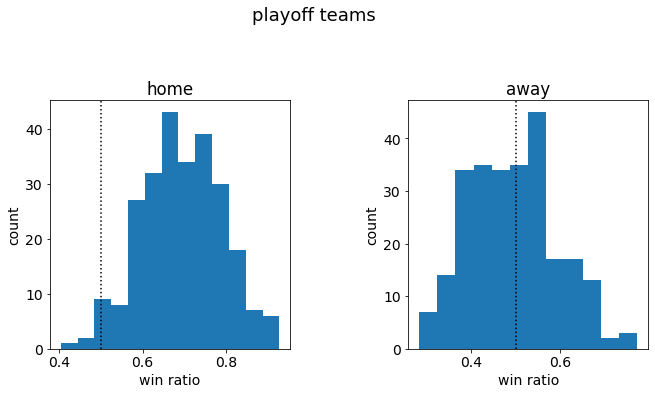

In [135]:
plt.rc('font', size=14)    #controls default text size

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(s_playoff_teams_home, bins='auto')
ax1.set(xlabel='win ratio', ylabel='count')
ax1.set_title('home')
ax1.axvline(x=0.5, ymin=0, ymax=50, color='k', linestyle=':')

ax2.hist(s_playoff_teams_away, bins='auto')
ax2.set(xlabel='win ratio', ylabel='count')
ax2.set_title('away')
ax2.axvline(x=0.5, ymin=0, ymax=50, color='k', linestyle=':')

fig.suptitle('playoff teams', fontsize=18)
fig.tight_layout(w_pad=2)
fig.set_figwidth(10)
fig.set_figheight(6)

plt.show()

As we see from the histogram plot, most of the playoff teams have home-win ratio larger than 0.5,  
and the away-win ratio seems around 0.5.  
let's see how what is the percentage is.

In [136]:
num_home_win_team = s_playoff_teams_home[s_playoff_teams_home > 0.5].shape[0]
ratio = num_home_win_team / s_playoff_teams_home.shape[0]

print(f'For playoff teams across many seasons, {ratio:.2%} won more than half of their home games.')

For playoff teams across many seasons, 96.48% won more than half of their home games.


In [137]:
num_away_win_team = s_playoff_teams_away[s_playoff_teams_away > 0.5].shape[0]
away_ratio = num_away_win_team / s_playoff_teams_away.shape[0]

print(f'For playoff teams across many seasons, only {away_ratio:.2%} won more than half of their away games.')

For playoff teams across many seasons, only 44.53% won more than half of their away games.


**How did the non-playoff teams perform in their home-games vs away-games?** 

In [138]:
seasons = range(first_season, 2019) # exclude 2019 and beyond

non_playoff_teams_home_win_ratios = []
non_playoff_teams_away_win_ratios = []

for s in seasons:
    games = all_games[all_games['SEASON'] == s]
    team_ids = non_playoff_team_ids(games)
    ratios = [home_game_win_ratio(games, id) for id in team_ids]
    ratios_away = [away_game_win_ratio(games, id) for id in team_ids]
    non_playoff_teams_home_win_ratios.extend(ratios)
    non_playoff_teams_away_win_ratios.extend(ratios_away)

s_non_playoff_teams_home = pd.Series(non_playoff_teams_home_win_ratios)
s_non_playoff_teams_away = pd.Series(non_playoff_teams_away_win_ratios)

print('non-playoff teams overall win ratios')
print('home:', s_non_playoff_teams_home.describe(), sep='\n')
print()
print('away:', s_non_playoff_teams_away.describe(), sep='\n')

non-playoff teams overall win ratios
home:
count    223.000000
mean       0.461329
std        0.117119
min        0.147059
25%        0.384358
50%        0.466667
75%        0.545455
max        0.750000
dtype: float64

away:
count    223.000000
mean       0.289334
std        0.094808
min        0.066667
25%        0.219512
50%        0.288889
75%        0.348837
max        0.555556
dtype: float64


Let's see how the non-playoff teams did.

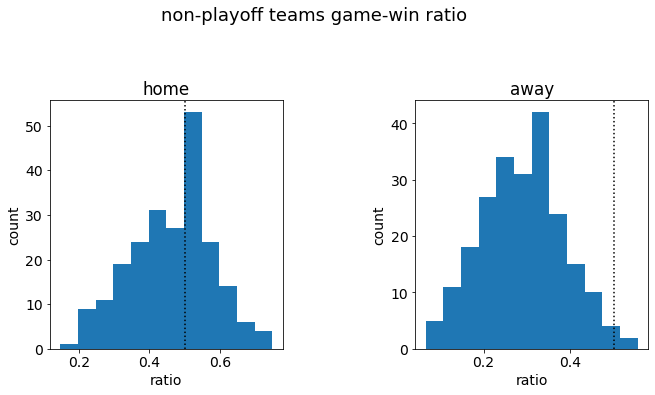

In [139]:
plt.rc('font', size=14)    #controls default text size

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(s_non_playoff_teams_home, bins='auto')
ax1.set(xlabel='ratio', ylabel='count')
ax1.set_title('home')
ax1.axvline(x=0.5, ymin=0, ymax=50, color='k', linestyle=':')

ax2.hist(s_non_playoff_teams_away, bins='auto')
ax2.set(xlabel='ratio', ylabel='count')
ax2.set_title('away')
ax2.axvline(x=0.5, ymin=0, ymax=50, color='k', linestyle=':')

fig.suptitle('non-playoff teams game-win ratio', fontsize=18)
fig.tight_layout(w_pad=2)
fig.set_figwidth(10)
fig.set_figheight(6)

plt.show()

Just as playoff teams, non-playoff teams also have a higher win ratio at home than away. 
 
It seems like for both playoff teams and non-playoff teams, there is  
a significant difference of about 0.2 between the win ratios of home  
and away games. Let's verify.  

In [140]:
diff_playoff_teams = s_playoff_teams_home.mean() - s_playoff_teams_away.mean()
diff_non_playoff_teams = s_non_playoff_teams_home.mean() - s_non_playoff_teams_away.mean()

print(f'Playoff teams average home away win ratio difference: {diff_playoff_teams:.3f}.')
print(f'Non-playoff teams average home away win ratio difference: {diff_non_playoff_teams:.3f}.')

Playoff teams average home away win ratio difference: 0.200.
Non-playoff teams average home away win ratio difference: 0.172.


So, it seems like that having a win ratio at home-games higher than away-games is a  
situation across all the teams. **But how confident can we say that the home-win ratio  
is actually diffrent from away-win ratio?**

Define a permutation test function

In [141]:
def permutation_test(data_array_a: np.ndarray, data_array_b: np.ndarray):
    data_mean_a = data_array_a.mean()
    data_mean_b = data_array_b.mean()
    extreme_mean_difference = abs(data_mean_a - data_mean_b)
    total_data = np.hstack([data_array_a, data_array_b])
    number_extreme_values = 0.0
    for _ in range(30000):
        np.random.shuffle(total_data)
        sample_a = total_data[:data_array_a.size]
        sample_b = total_data[data_array_a.size:]
    if abs(sample_a.mean() - sample_b.mean()) >= extreme_mean_difference:
        number_extreme_values += 1
    p_value = number_extreme_values / 30000
    return p_value

First look at playoff teams:

In [142]:
p_value_playoff_team = permutation_test(s_playoff_teams_home, s_playoff_teams_away)

assert p_value_playoff_team < 0.05
print(p_value_playoff_team)

0.0


Not surprisingly, for playoff teams, their home-win ratio is statistically different from away-win ratio.

Now look at non-playoff teams:

In [143]:
p_value_nonplayoff_team = permutation_test(s_non_playoff_teams_home, s_non_playoff_teams_away)

assert p_value_nonplayoff_team < 0.05
print(p_value_nonplayoff_team)

0.0


Still, for non-playoff teams, their home-win ratio is also statistically different from away-win ratio.

So we are pretty confident to say that, **for all nba teams in from 2003 to 2019 seasons, they hava   
a higher and statistically different home-win ratio than away-win ratio**.

**How much is the difference between home-win ratio and away-win ratio?**

In [144]:
differences_home_away_ratio = []

for s in all_seasons:
    games = all_games[all_games['SEASON'] == s]
    teams = set(games.HOME_TEAM_ID)
    for t in teams:
        home_win_ratio = home_game_win_ratio(games, t)
        away_win_ratio = away_game_win_ratio(games, t)
        differences_home_away_ratio.append((s, t, home_win_ratio - away_win_ratio))

df_ratio_differences = pd.DataFrame(differences_home_away_ratio, 
                                    columns=['SEASON', 'TEAM_ID', 'HOME_AWAY_WIN_RATIO_DIFFERENCE'])


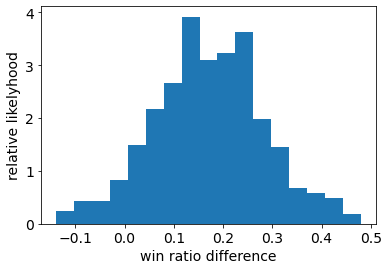

In [145]:
plt.hist(df_ratio_differences.HOME_AWAY_WIN_RATIO_DIFFERENCE, bins='auto', density=True)
plt.xlabel('win ratio difference')
plt.ylabel('relative likelyhood')
plt.show()

In [151]:
from scipy import stats

x = df_ratio_differences.HOME_AWAY_WIN_RATIO_DIFFERENCE

(test_statistic, critical_values, significance_level) = stats.anderson(x, dist='norm')

assert np.all(
    np.array(critical_values) > test_statistic) 

The anderson test confirms that the home-away-win-ratio-difference follow a normal distribution.  
Based on this fact, we can learn more about the ratio difference.

In [158]:
from scipy import stats

(loc, scale) = shape_parameters = stats.norm.fit(x)

print(shape_parameters)

end_points = stats.norm.interval(0.95, loc=loc, scale=scale)
print(end_points)

(0.17135200596992045, 0.11277576596957863)
(-0.0496844336593715, 0.3923884455992124)


So, on average, home-win-ratio is 0.17 higher than away-win-ratio.  
We are 95 percent confident that for any given time, the home-away-win-ratio-difference  
will be within the interval from -0.049 to 0.39, so most of the teams will win more at home court.  

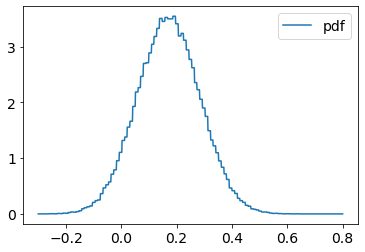

In [164]:
x = np.linspace(-0.3, 0.8, num=1000)

data = stats.norm.rvs(size=100000, loc=loc, scale=scale)
hist = np.histogram(data, bins=100)
hist_dist = stats.rv_histogram(hist)

plt.plot(x, hist_dist.pdf(x), label='pdf')
plt.legend()
plt.show()

Now the more difficult question is: **Why NBA teams win more games at home than away?**   
This question will be left for future projects to answer.